# Step Size Analysis (step_size=0.1)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

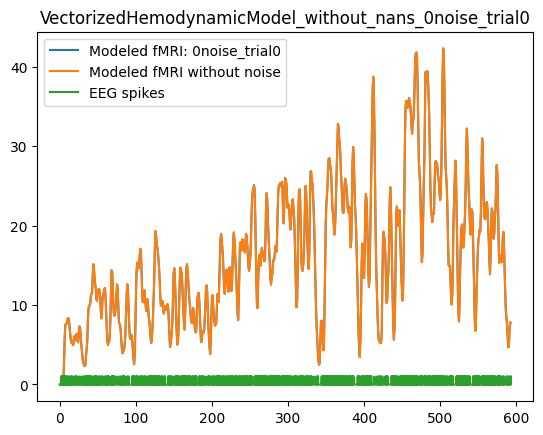

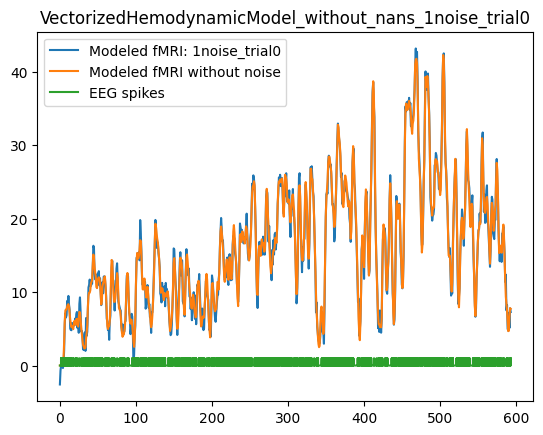

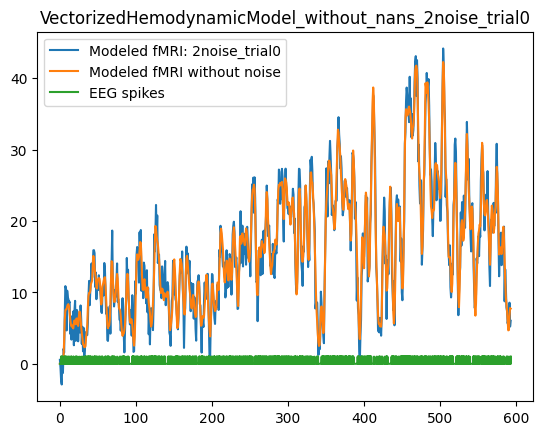

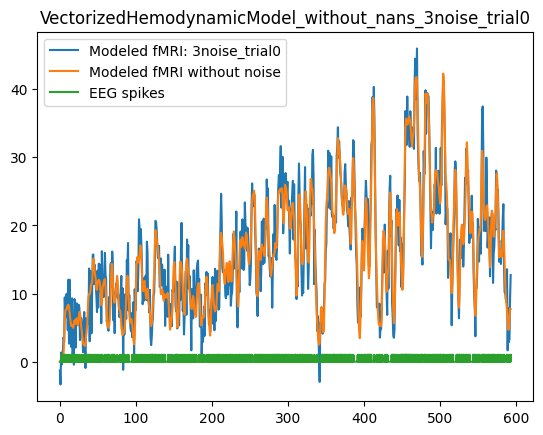

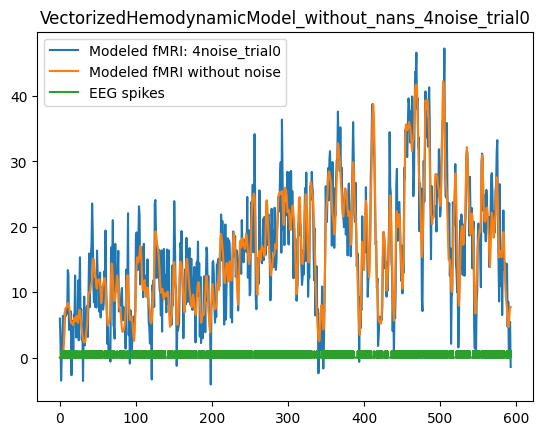

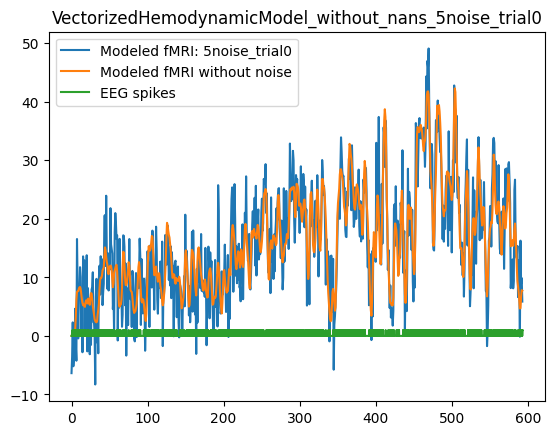

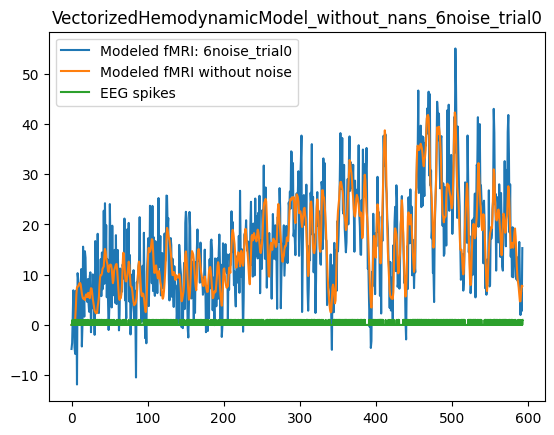

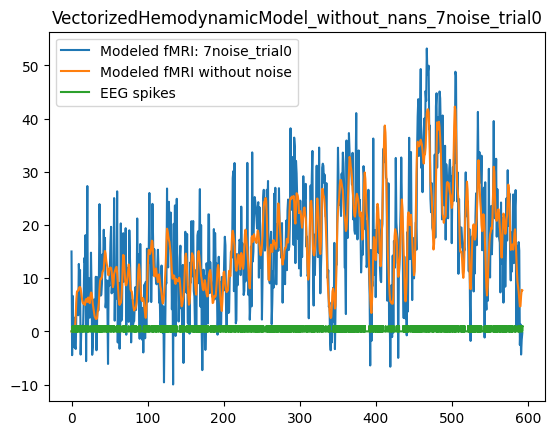

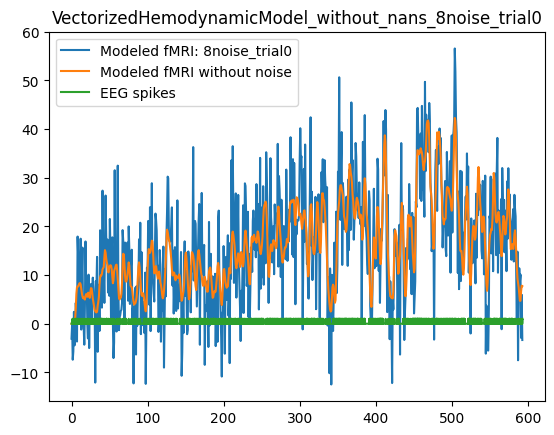

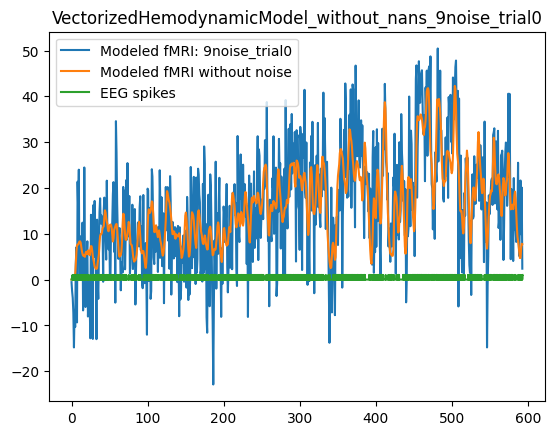

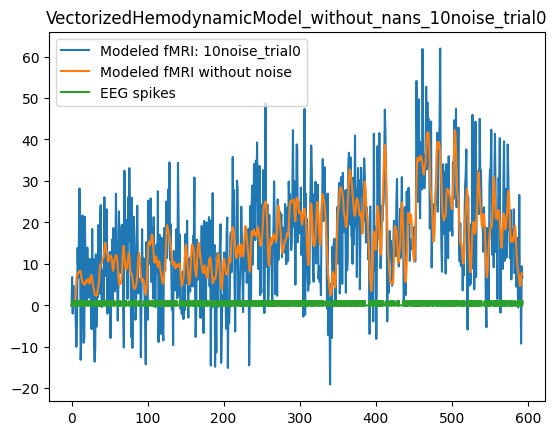

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.1

filename_substring = f'effect_of_step_size_{step_size}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3. ]

Tau target: 1.25, Range:
[0.75 0.85 0.95 1.05 1.15 1.25 1.35 1.45 1.55 1.65 1.75]

Alpha target: 2, Range:
[1.75 1.85 1.95 2.05 2.15 2.25 2.35]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.25, alpha=2


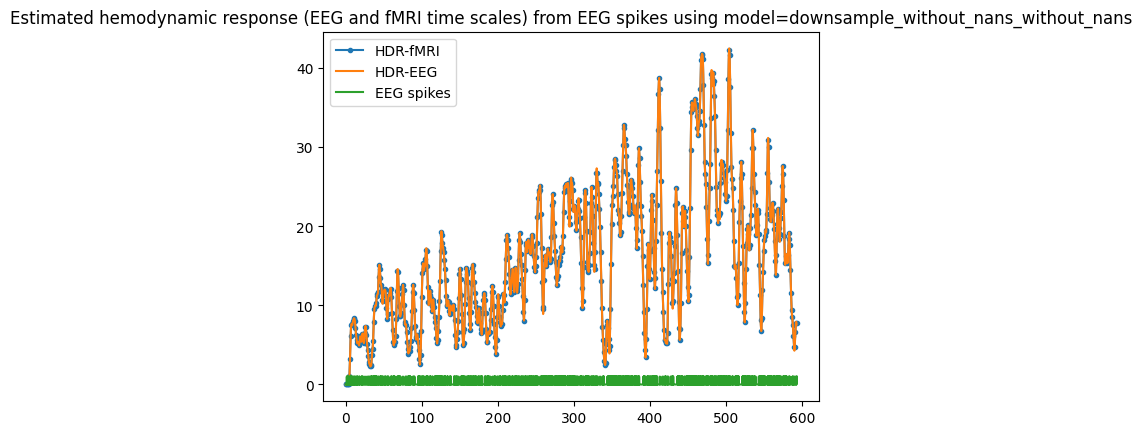

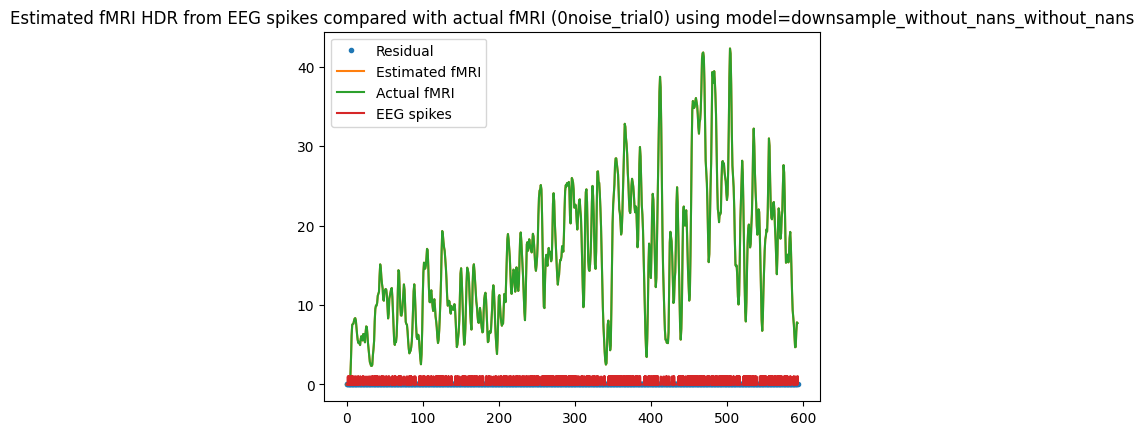

Residual Variance is 0.000000


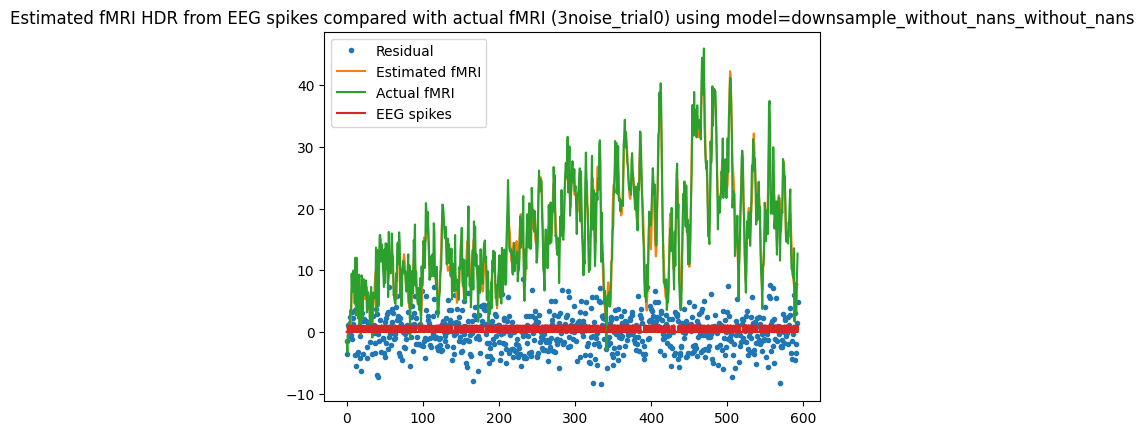

Residual Variance is 8.494682


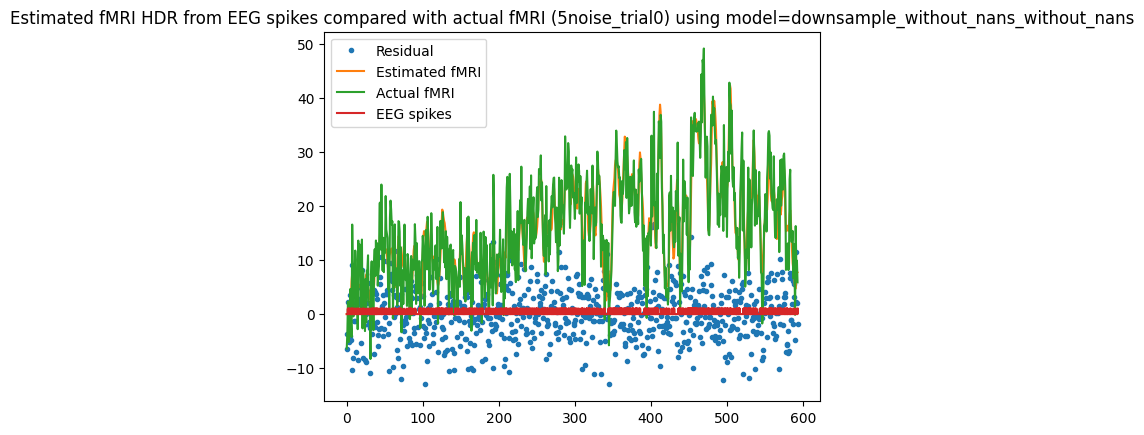

Residual Variance is 22.782967


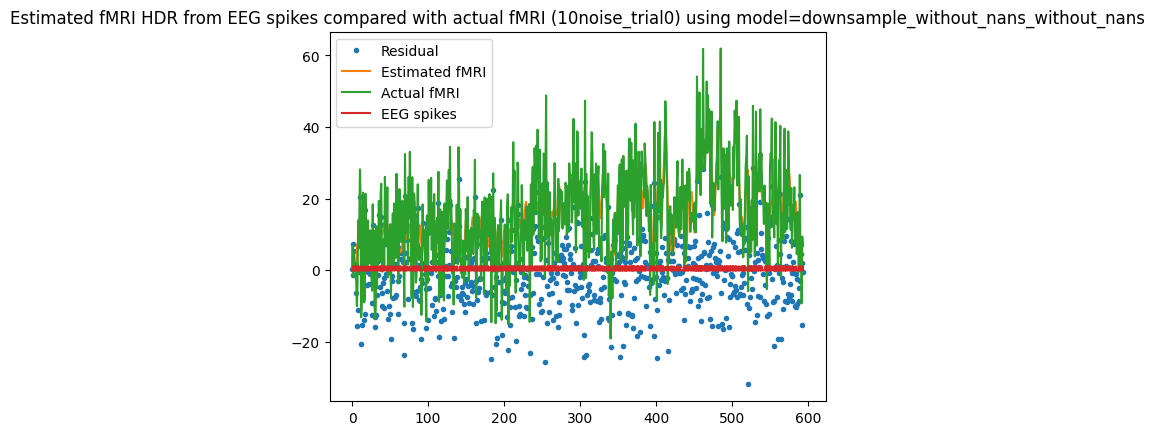

Residual Variance is 98.573997


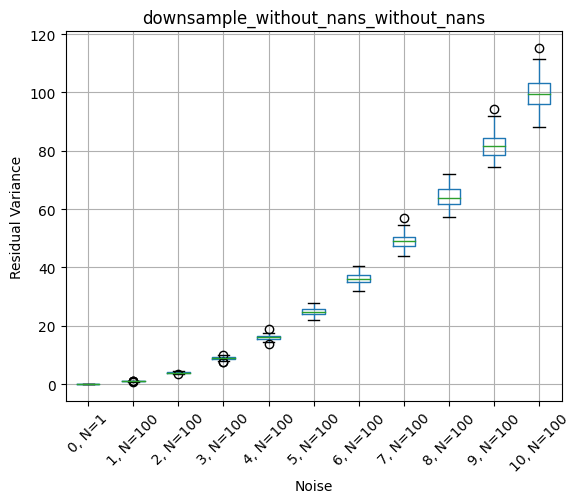

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.25, alpha=2


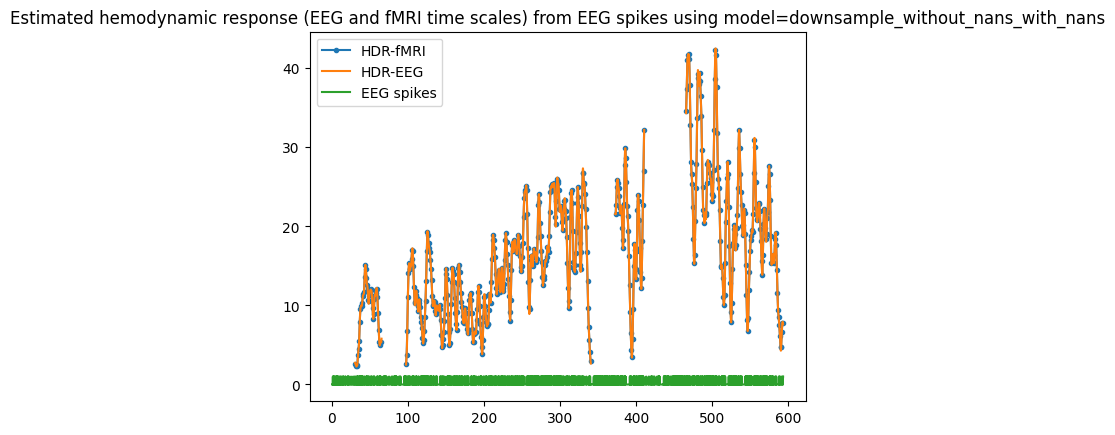

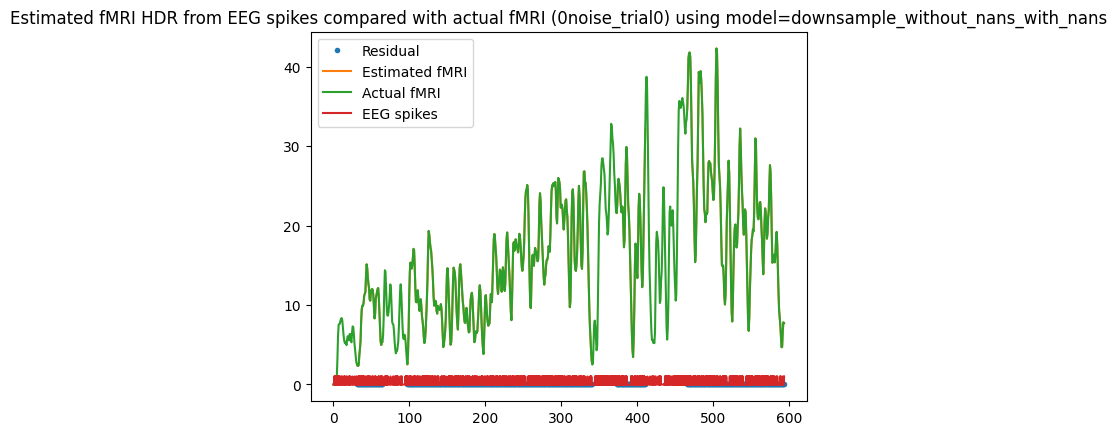

Residual Variance is 0.000000


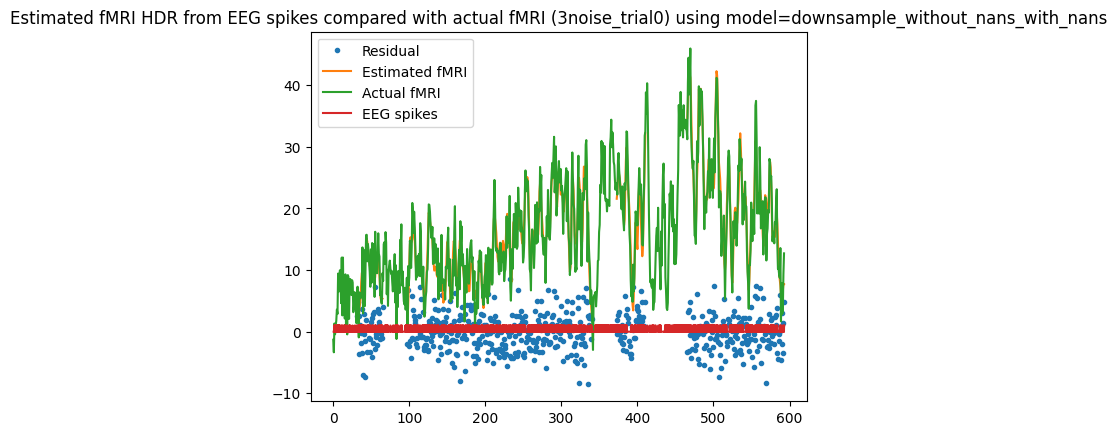

Residual Variance is 8.838005


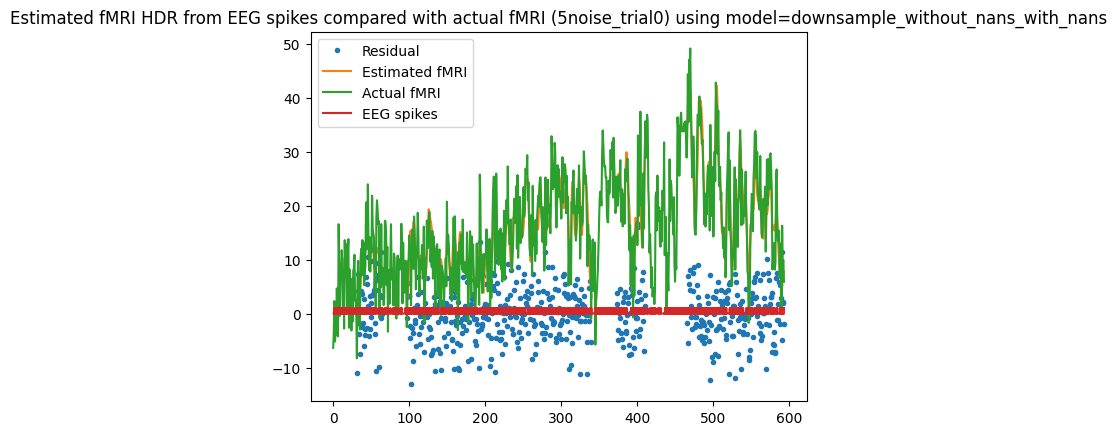

Residual Variance is 22.917203


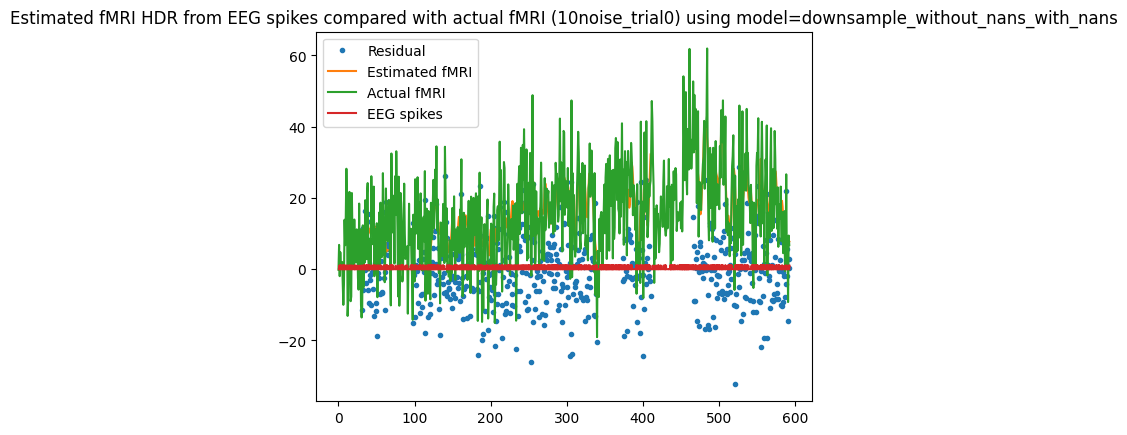

Residual Variance is 98.805227


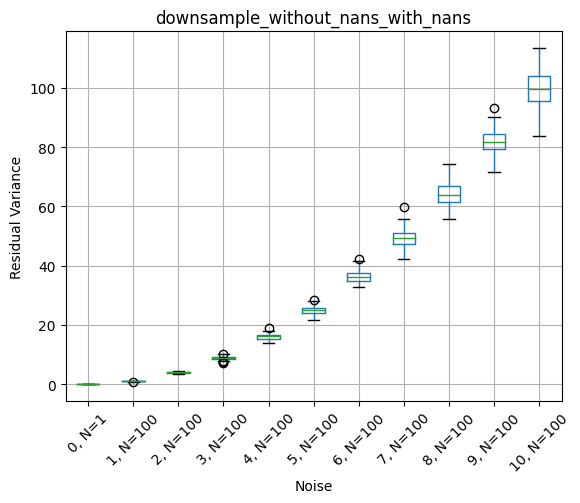

In [70]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False


## Generate/Load the full dataset

In [9]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


Found previously run data. Enter name to reuse or "none" to recalculate.
['effect_of_step_size_0.1_2023-04-11_14:38.csv']
Default (effect_of_step_size_0.1_2023-04-11_14:38.csv)
none


In [10]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.1
Scoring delta=1.2000000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.6000000000000005
Scoring delta=1.7000000000000006
Scoring delta=1.8000000000000007
Scoring delta=1.9000000000000008
Scoring delta=2.000000000000001
Scoring delta=2.100000000000001
Scoring delta=2.200000000000001
Scoring delta=2.300000000000001
Scoring delta=2.4000000000000012
Scoring delta=2.5000000000000013
Scoring delta=2.6000000000000014
Scoring delta=2.7000000000000015
Scoring delta=2.8000000000000016
Scoring delta=2.9000000000000017
Scoring delta=3.0000000000000018


delta                 tau               alpha  \
0                    1.0                0.75                1.75   
1                    1.0                0.75                1.75   
2                    1.0                0.75                1.85   
3                    1.0                0.75                1.85   
4                    1.0                0.75  1.9500000000000002   
...                  ...                 ...                 ...   
3229  3.0000000000000018  1.7499999999999998  2.1500000000000004   
3230  3.0000000000000018  1.7499999999999998  2.2500000000000004   
3231  3.0000000000000018  1.7499999999999998  2.2500000000000004   
3232  3.0000000000000018  1.7499999999999998  2.3500000000000005   
3233  3.0000000000000018  1.7499999999999998  2.3500000000000005   

                                model_name       0noise_trial0  \
0     downsample_without_nans_without_nans   43.01781141842791   
1        downsample_without_nans_with_nans   39.26920114811135   
2     downsample_without_nans_without_nans     41.301824238503   
3        downsample_without_nans_with_nans  37.799029561920946   
4     downsample_without_nans_without_nans   39.55420948351525   
...                                    ...                 ...   
3229     downsample_without_nans_with_nans  13.906967719015656   
3230  downsample_without_nans_without_nans  16.757261105650475   
3231     downsample_without_nans_with_nans  15.288021480333702   
3232  downsample_without_nans_without_nans   18.30364984038292   
3233     downsample_without_nans_with_nans  16.639320706472677   

           1noise_trial0       2noise_trial0       3noise_trial0  \
0     44.515797336137425   48.51594744622308   50.15318996010266   
1     40.392293766658455   44.43219423967018  47.371616274010115   
2      42.77178846746136   46.72509867762601   48.43300781661477   
3      38.90308661234119   42.88104582539962  45.872948747559455   
4      40.99629649092575   44.90101104866742   46.68439071026114   
...                  ...                 ...                 ...   
3229   15.12888130952585  19.135272951507325   23.62552279614185   
3230  17.904573558286824  21.877851684736356   25.79382369884822   
3231  16.521004391147112   20.57610451657122  25.014312935933617   
3232  19.465010186927817  23.499056683736832  27.321976027432076   
3233   17.88311813308438  21.983619595505107  26.367259156411944   

           4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0     59.144374062927305  63.301756477020696  ...  43.420298328769746   
1      54.74680717982274   59.55651653058819  ...    39.6062217234224   
2      57.43580507643899  61.629452124966654  ...  41.712357399067514   
3     53.342205361052635   58.11253128865718  ...   38.14987811365749   
4      55.69101219016584  59.934406887105354  ...   39.97365137166903   
...                  ...                 ...  ...                 ...   
3229  31.139253476400114   36.85773238941709  ...  14.714518248873684   
3230   33.76758756491736   38.69395501506118  ...  17.655368082296693   
3231   32.40854453515769   38.21366686575647  ...  16.072380095623593   
3232  35.243228919350834    40.1681895710582  ...  19.181902754008664   
3233   33.64636523836829   39.53745178854645  ...  17.401247171867052   

          2noise_trial99      3noise_trial99      4noise_trial99  \
0      48.78575379987207   51.06426907748391   56.74063264407992   
1      45.13133607437067   47.95531047843244   56.78635986694462   
2     46.992660937107395  49.389057572284806  55.060634430062706   
3      43.59798648186024   46.55524411717383   55.27343284735329   
4      45.16502006989727  47.685268066159125    53.3549329235161   
...                  ...                 ...                 ...   
3229  18.414357175324234   21.38973438536469  31.263312762595454   
3230   21.32157179225779  24.301118368945787   33.33686500800252   
3231   19.83970917034199   22.69958333639049   32.74482580175496   
3232  22.912384482435108   25.76634

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 0.0031714081768617662; at
      delta   tau  alpha
1924    2.2  1.25   2.05


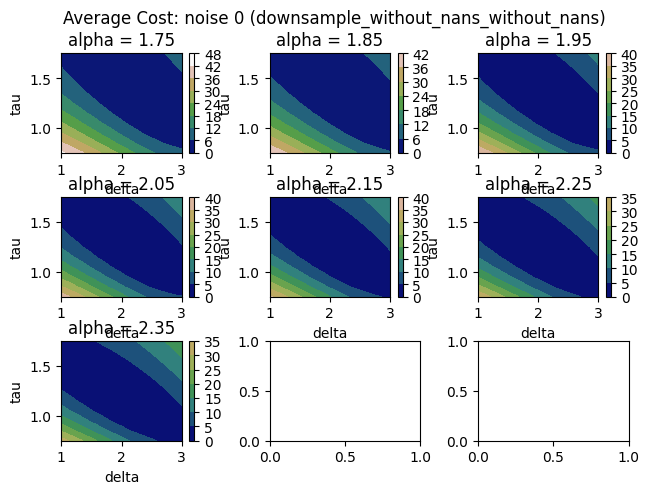

delta   tau  alpha  \
0       1.0  0.75   1.75   
2       1.0  0.75   1.85   
4       1.0  0.75   1.95   
6       1.0  0.75   2.05   
8       1.0  0.75   2.15   
...     ...   ...    ...   
3224    3.0  1.75   1.95   
3226    3.0  1.75   2.05   
3228    3.0  1.75   2.15   
3230    3.0  1.75   2.25   
3232    3.0  1.75   2.35   

      Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                             43.017811             
2                                             41.301824             
4                                             39.554209             
6                                             37.780827             
8                                             35.987850             
...                                                 ...             
3224                                          12.035360             
3226                                          13.612216             
3228                                          15.190117             
3230                                          16.757261             
3232                                          18.303650             

[1617 rows x 4 columns]

In [11]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [12]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    2.2  1.25   2.05

### Local Minima Analysis

In [13]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration      cost  delta   tau  alpha
0      0         0  0.008849    2.1  1.15   2.35
1      0         0  0.003171    2.2  1.25   2.05
2      0         0  0.029532    2.3  1.35   1.75

In [14]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [15]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration      cost  delta   tau  alpha
2      0         0  0.029532    2.3  1.35   1.75

In [20]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.008849    2.1  1.15   2.35

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 0.0031312701555072375; at
      delta   tau  alpha
1925    2.2  1.25   2.05


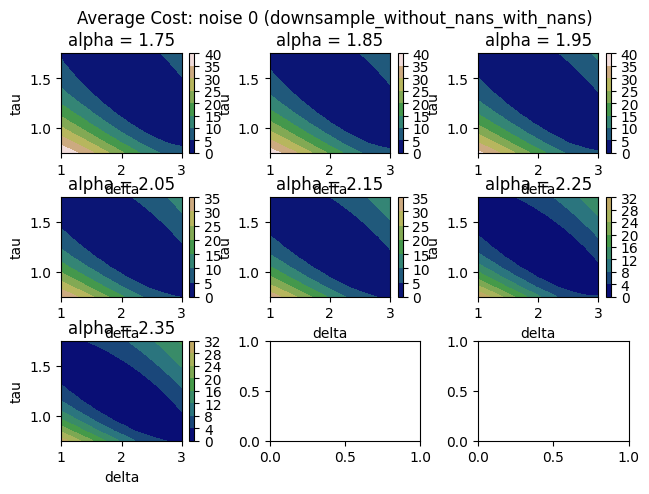

delta   tau  alpha  \
1       1.0  0.75   1.75   
3       1.0  0.75   1.85   
5       1.0  0.75   1.95   
7       1.0  0.75   2.05   
9       1.0  0.75   2.15   
...     ...   ...    ...   
3225    3.0  1.75   1.95   
3227    3.0  1.75   2.05   
3229    3.0  1.75   2.15   
3231    3.0  1.75   2.25   
3233    3.0  1.75   2.35   

      Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                             39.269201          
3                                             37.799030          
5                                             36.290082          
7                                             34.747276          
9                                             33.176001          
...                                                 ...          
3225                                          11.093203          
3227                                          12.505089          
3229                                          13.906968          
3231                                          15.288021          
3233                                          16.639321          

[1617 rows x 4 columns]

In [21]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [22]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    2.2  1.25   2.05

### Local Minima Analysis

In [23]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration      cost  delta   tau  alpha
0      0         0  0.008633    2.1  1.15   2.35
1      0         0  0.003131    2.2  1.25   2.05
2      0         0  0.028130    2.4  1.35   1.75

In [24]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [25]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration     cost  delta   tau  alpha
2      0         0  0.02813    2.4  1.35   1.75

In [30]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.008633    2.1  1.15   2.35

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0063607212715586; at
      delta   tau  alpha
1924    2.2  1.25   2.05


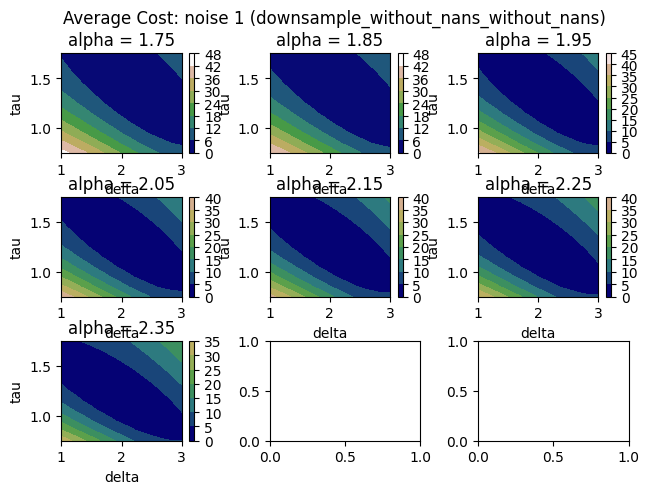

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.969703933396664; at
      delta   tau  alpha
2076    2.3  1.25   1.95


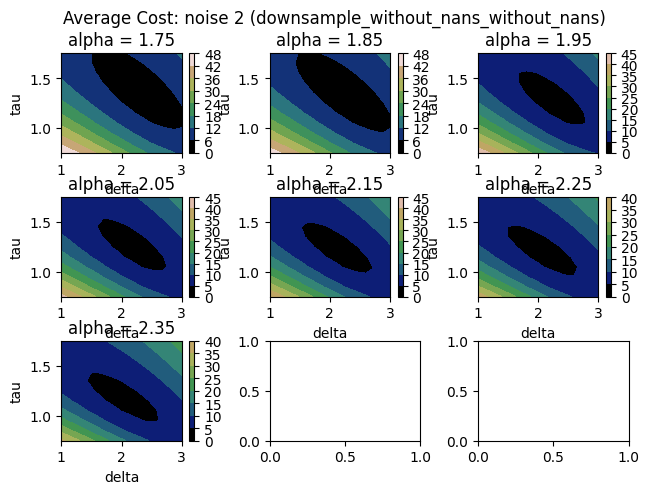

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.930781937881719; at
      delta   tau  alpha
1924    2.2  1.25   2.05


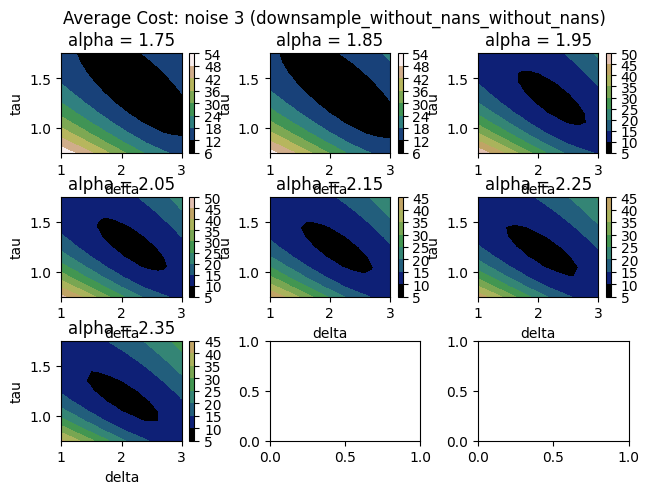

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.00248290565852; at
      delta   tau  alpha
1924    2.2  1.25   2.05


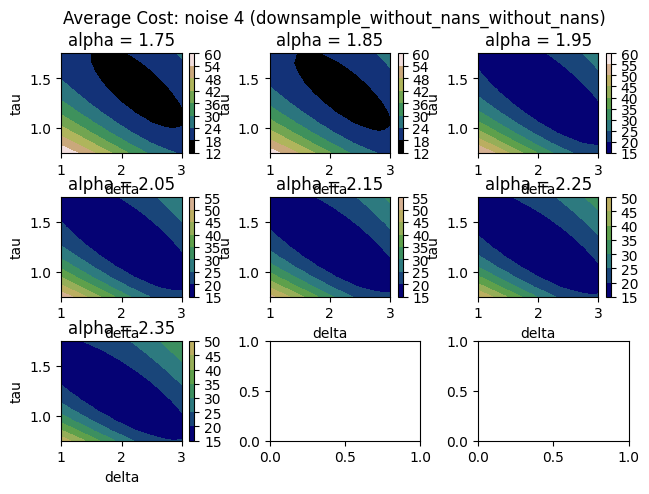

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.79748549931008; at
      delta   tau  alpha
2076    2.3  1.25   1.95


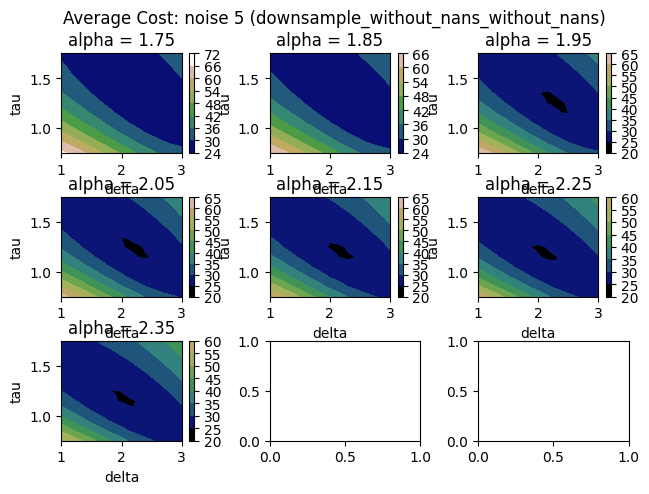

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.169866417127054; at
      delta   tau  alpha
2076    2.3  1.25   1.95


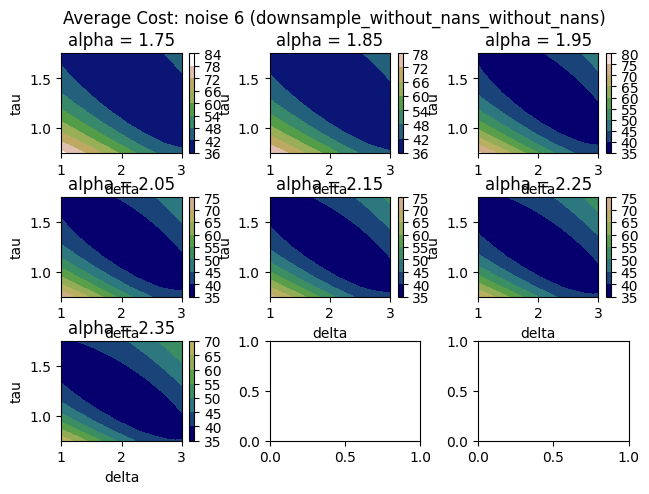

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.068178143311954; at
      delta   tau  alpha
1924    2.2  1.25   2.05


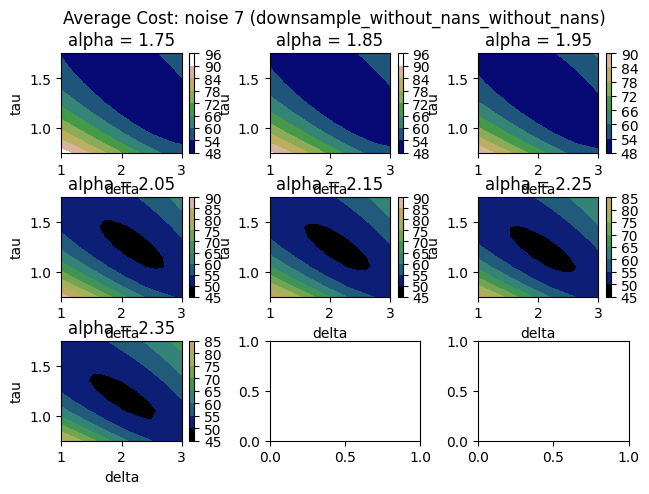

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.26146687511336; at
      delta   tau  alpha
2076    2.3  1.25   1.95


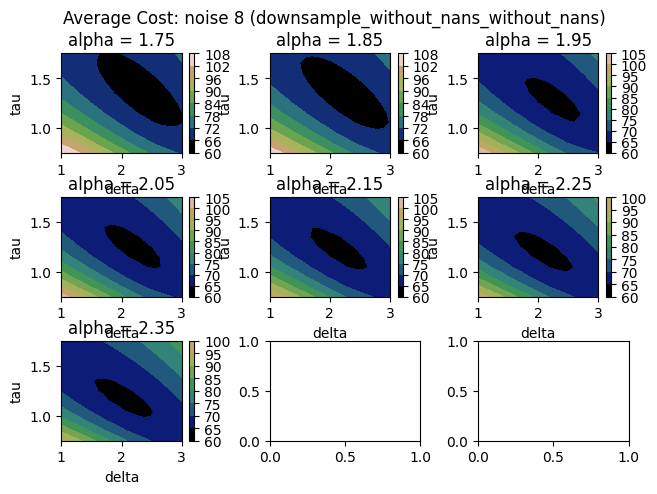

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.46254260124934; at
      delta   tau  alpha
1924    2.2  1.25   2.05


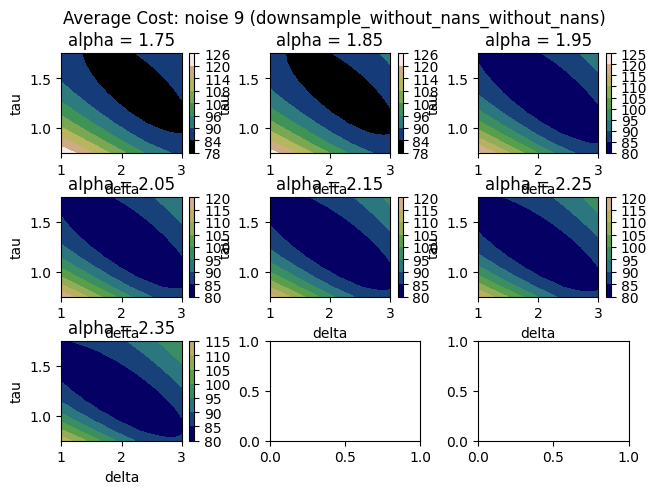

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.73079448430718; at
      delta   tau  alpha
2076    2.3  1.25   1.95


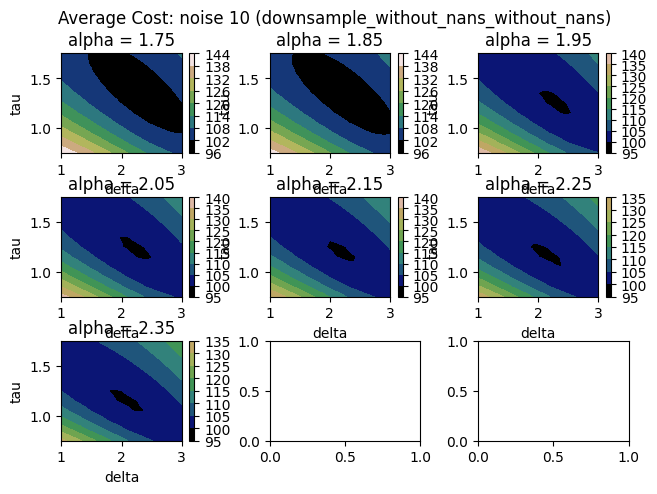

In [33]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

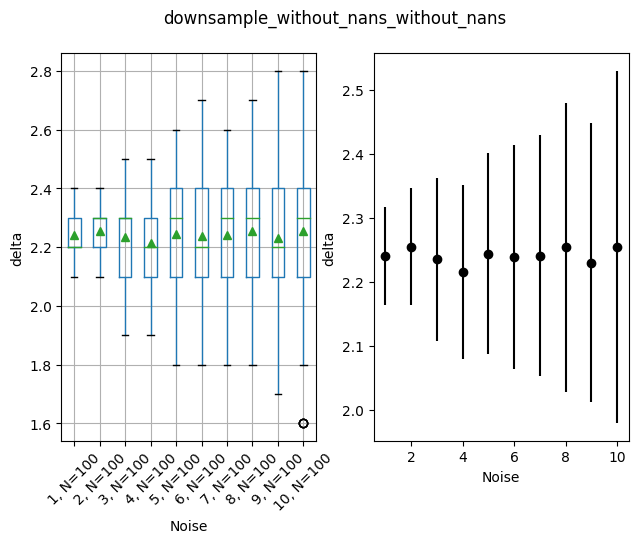

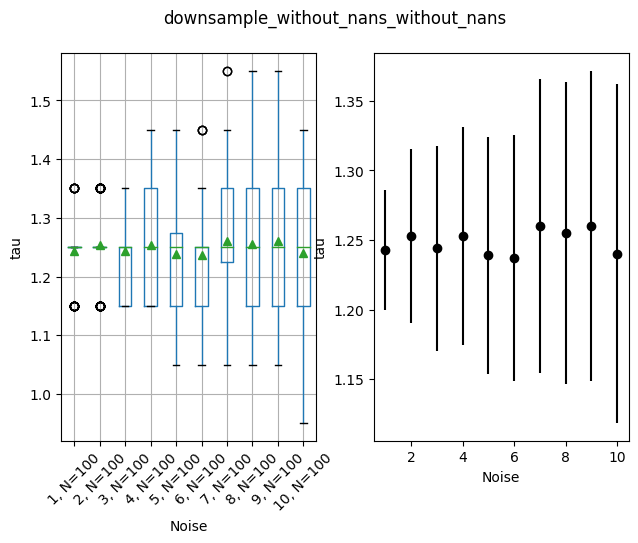

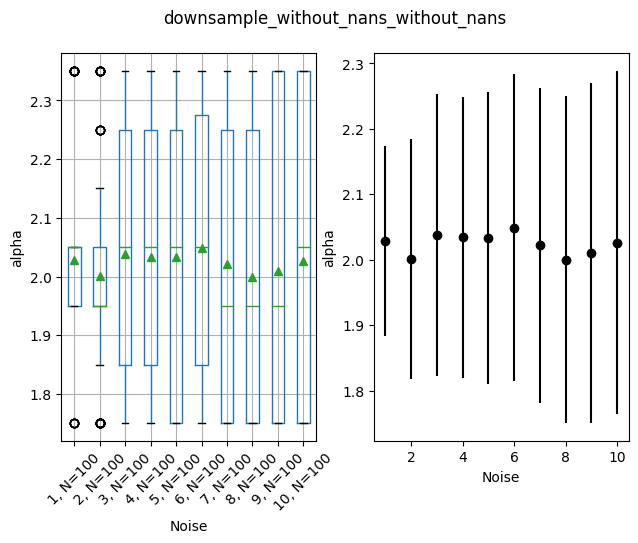

In [34]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.006426987429114; at
      delta   tau  alpha
1925    2.2  1.25   2.05


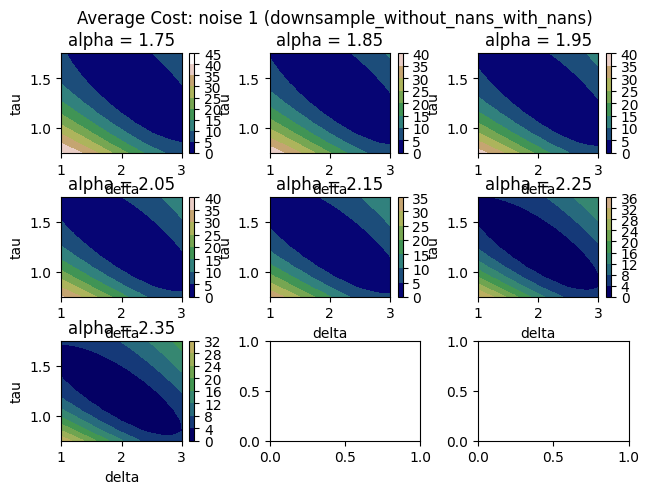

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.983802474518649; at
      delta   tau  alpha
2077    2.3  1.25   1.95


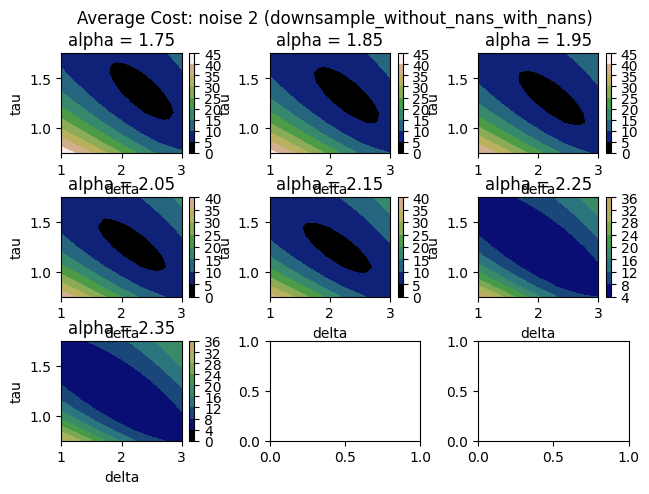

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.914133693013849; at
      delta   tau  alpha
1925    2.2  1.25   2.05


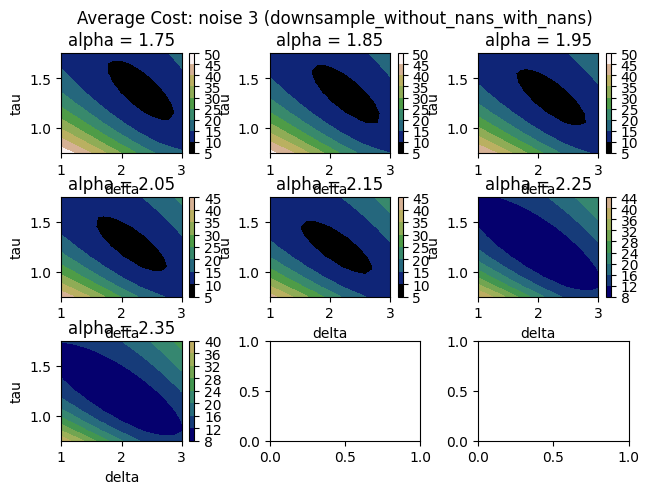

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.016480523734103; at
      delta   tau  alpha
1925    2.2  1.25   2.05


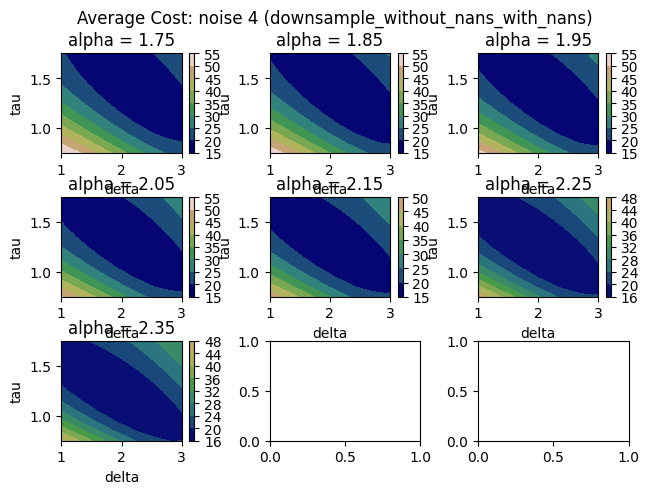

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.925905751896565; at
      delta   tau  alpha
2077    2.3  1.25   1.95


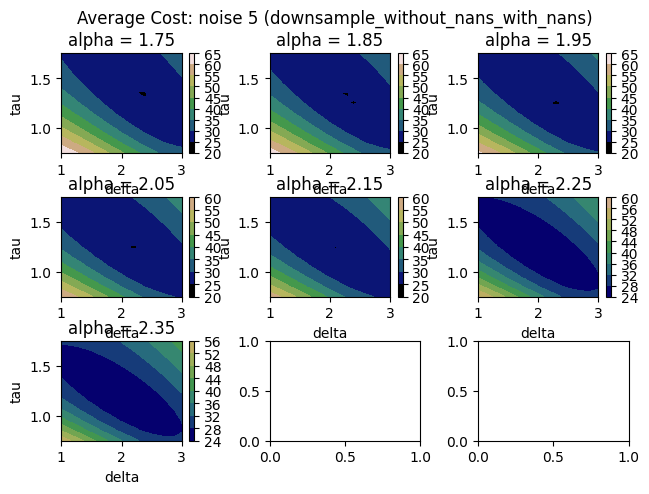

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.38048021879844; at
      delta   tau  alpha
1925    2.2  1.25   2.05


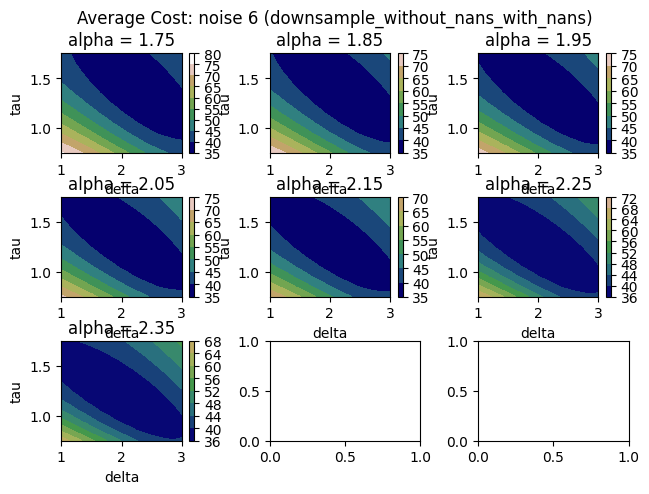

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.22194878456611; at
      delta   tau  alpha
1925    2.2  1.25   2.05


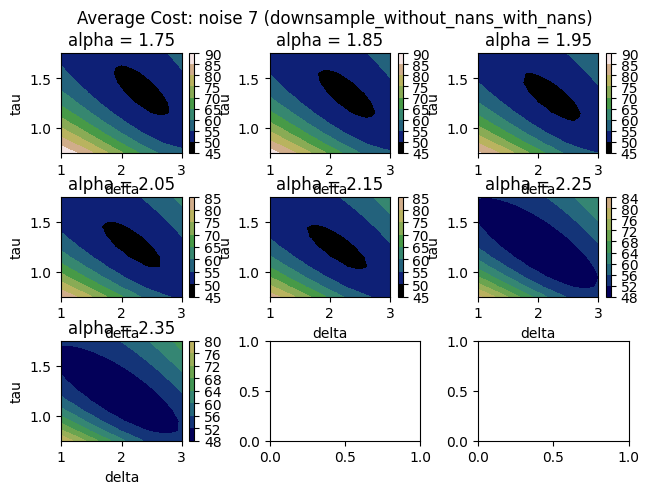

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.20767565523698; at
      delta   tau  alpha
1925    2.2  1.25   2.05


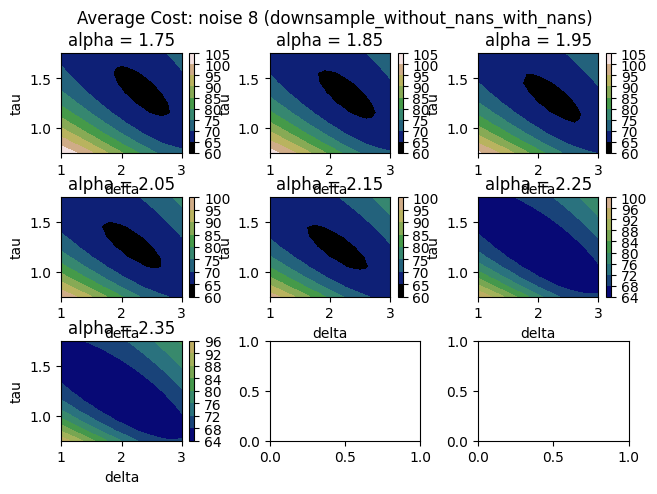

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.75794614276688; at
      delta   tau  alpha
1925    2.2  1.25   2.05


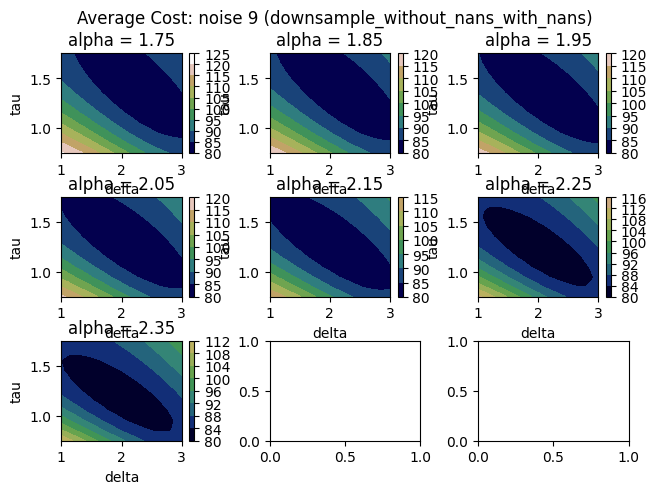

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.68422430001075; at
      delta   tau  alpha
2077    2.3  1.25   1.95


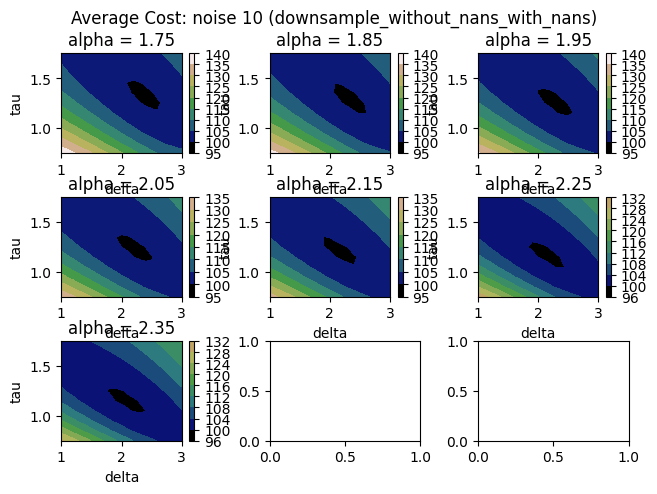

In [67]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


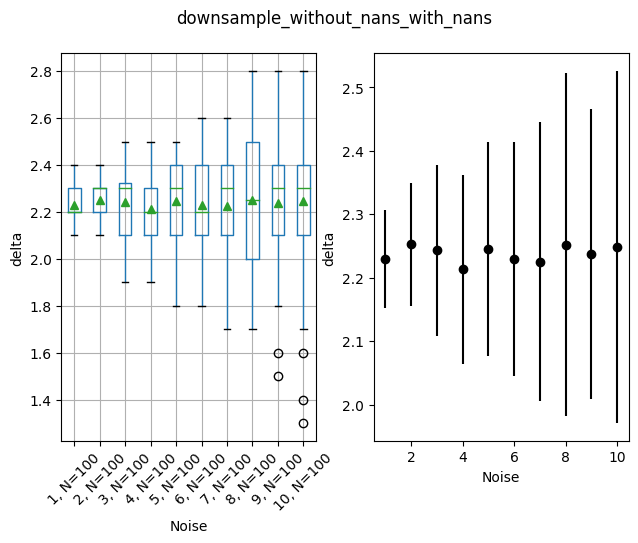

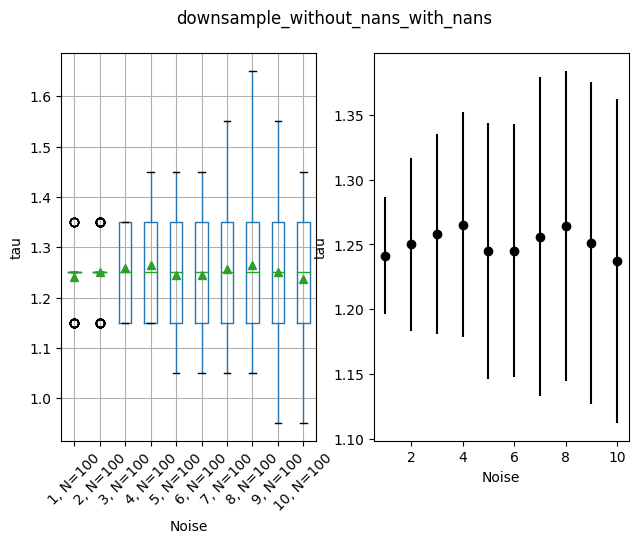

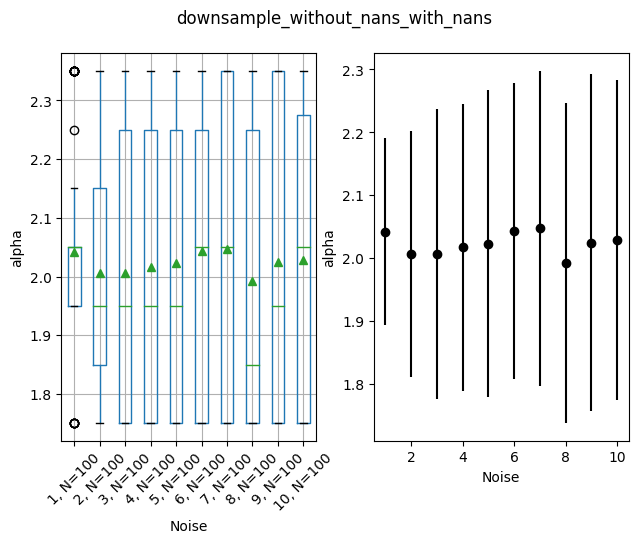

In [68]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [37]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [38]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [39]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         0    0.989373   2.100000000000001                1.15   
1         1         1    0.959603   2.100000000000001                1.15   
2         1         2    0.952661   2.100000000000001                1.15   
3         1         3    1.076219   2.100000000000001                1.15   
4         1         4    1.020994   2.100000000000001                1.15   
...     ...       ...         ...                 ...                 ...   
2274     10        52  100.772804  2.8000000000000016  1.0499999999999998   
2275     10         5   95.463619  2.8000000000000016                1.15   
2276     10        80   97.885362  2.8000000000000016                1.15   
2277     10         7   98.318187  2.8000000000000016                1.25   
2278     10        44   89.719106  2.8000000000000016                1.25   

                   alpha  
0     2.3500000000000005  
1     2.3500000000000005  
2     2.3500000000000005  
3     2.3500000000000005  
4     2.3500000000000005  
...                  ...  
2274                1.85  
2275                1.75  
2276  1.9500000000000002  
2277                1.75  
2278                1.75  

[2279 rows x 6 columns]

In [40]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
1                        2.76
2                        2.58
3                        2.45
4                        2.34
5                        2.20
6                        2.28
7                        2.09
8                        2.19
9                        1.92
10                       1.98

#### Local minima at edges

In [41]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [43]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [44]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [45]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
199       1         0    1.011309   2.300000000000001  1.3499999999999999   
200       1         2    0.961681   2.300000000000001  1.3499999999999999   
201       1         6    1.002047   2.300000000000001  1.3499999999999999   
202       1         9    1.020524   2.300000000000001  1.3499999999999999   
203       1        11    1.024431   2.300000000000001  1.3499999999999999   
...     ...       ...         ...                 ...                 ...   
2272     10        19  103.570396  2.7000000000000015                1.25   
2273     10        27   97.307732  2.7000000000000015                1.25   
2275     10         5   95.463619  2.8000000000000016                1.15   
2277     10         7   98.318187  2.8000000000000016                1.25   
2278     10        44   89.719106  2.8000000000000016                1.25   

     alpha  
199   1.75  
200   1.75  
201   1.75  
202   1.75  
203   1.75  
...    ...  
2272  1.75  
2273  1.75  
2275  1.75  
2277  1.75  
2278  1.75  

[527 rows x 6 columns]

In [46]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        77      2   2.300000000000001   41    77      1  1.3499999999999999   
10       49      9  2.4000000000000012   13    49      4  1.3499999999999999   
2        61      2   2.300000000000001   31    61      1  1.3499999999999999   
3        52      4  2.4000000000000012   28    52      3  1.3499999999999999   
4        40      4   2.300000000000001   18    40      3  1.3499999999999999   
5        46      6   2.300000000000001   19    46      3  1.3499999999999999   
6        47      7  2.4000000000000012   14    47      3  1.3499999999999999   
7        48      5   2.300000000000001   17    48      4  1.3499999999999999   
8        55      8  2.4000000000000012   14    55      5  1.3499999999999999   
9        52     10  2.4000000000000012   12    52      5  1.3499999999999999   

            
      freq  
noise       
1       77  
10      19  
2       61  
3       50  
4       34  
5       35  
6       29  
7       29  
8       24  
9       20

In [47]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1         0    0.989373   2.100000000000001                1.15   
1         1         1    0.959603   2.100000000000001                1.15   
2         1         2    0.952661   2.100000000000001                1.15   
3         1         3    1.076219   2.100000000000001                1.15   
4         1         4    1.020994   2.100000000000001                1.15   
...     ...       ...         ...                 ...                 ...   
2185     10        94   99.961713   2.300000000000001  1.0499999999999998   
2212     10        95   95.087631  2.4000000000000012  1.0499999999999998   
2222     10        47  100.453474  2.4000000000000012                1.15   
2262     10        52  100.769870  2.6000000000000014                0.95   
2263     10        80   97.841319  2.6000000000000014  1.0499999999999998   

                   alpha  
0     2.3500000000000005  
1     2.3500000000000005  
2     2.3500000000000005  
3     2.3500000000000005  
4     2.3500000000000005  
...                  ...  
2185  2.3500000000000005  
2212  2.3500000000000005  
2222  2.3500000000000005  
2262  2.3500000000000005  
2263  2.3500000000000005  

[529 rows x 6 columns]

In [48]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                  tau                  
      count unique                top freq count unique   top freq
noise                                                             
1        96      1  2.100000000000001   96    96      1  1.15   96
10       41     11  2.200000000000001   11    41      5  1.15   13
2        73      3  2.100000000000001   70    73      1  1.15   73
3        57      5  2.100000000000001   40    57      3  1.15   54
4        42      4  2.100000000000001   29    42      2  1.15   41
5        38      7  2.100000000000001   12    38      3  1.15   27
6        49      6  2.100000000000001   15    49      3  1.15   37
7        43      8  2.100000000000001   11    43      3  1.15   26
8        45      9  2.000000000000001   10    45      4  1.15   20
9        45      8  2.100000000000001   10    45      4  1.15   19

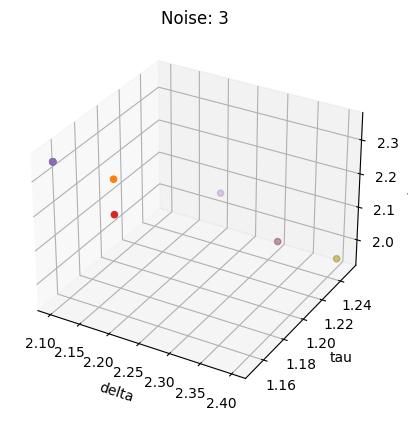

In [49]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

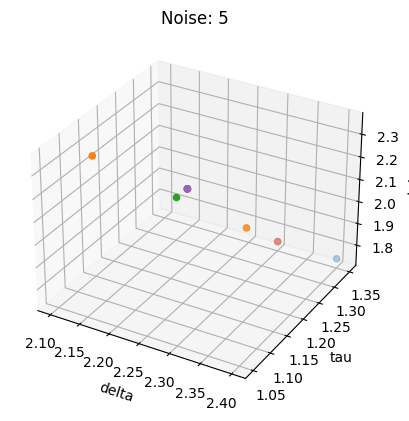

In [50]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

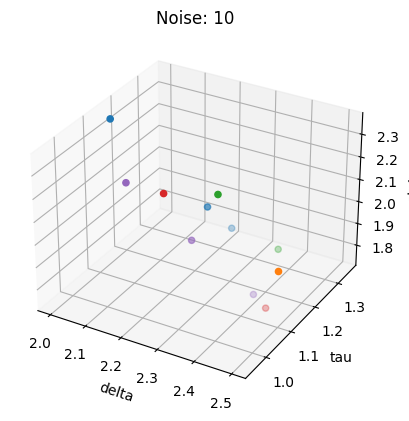

In [51]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [52]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [53]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [54]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta   tau  \
0         1        68    1.077001   2.000000000000001  1.15   
1         1         0    1.024440   2.100000000000001  1.15   
2         1         1    0.983740   2.100000000000001  1.15   
3         1         2    0.920909   2.100000000000001  1.15   
4         1         3    1.051746   2.100000000000001  1.15   
...     ...       ...         ...                 ...   ...   
2217     10        36  108.492900  2.7000000000000015  1.25   
2218     10         5   96.920887  2.8000000000000016  1.15   
2219     10        27   99.356543  2.8000000000000016  1.15   
2220     10        52  102.882361  2.8000000000000016  1.15   
2221     10        80  101.658682  2.8000000000000016  1.15   

                   alpha  
0     2.3500000000000005  
1     2.3500000000000005  
2     2.3500000000000005  
3     2.3500000000000005  
4     2.3500000000000005  
...                  ...  
2217                1.75  
2218                1.75  
2219                1.75  
2220                1.75  
2221  1.9500000000000002  

[2222 rows x 6 columns]

In [55]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
1                        2.75
2                        2.56
3                        2.43
4                        2.35
5                        2.11
6                        2.19
7                        2.09
8                        1.94
9                        2.03
10                       1.77

#### Local minima at edges

In [56]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [58]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [59]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [60]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
200       1         0    1.044306   2.300000000000001  1.3499999999999999   
201       1         2    0.923719   2.300000000000001  1.3499999999999999   
202       1         6    0.937992   2.300000000000001  1.3499999999999999   
203       1        11    0.979499   2.300000000000001  1.3499999999999999   
204       1        15    0.989865   2.300000000000001  1.3499999999999999   
...     ...       ...         ...                 ...                 ...   
2216     10         7   98.678767  2.7000000000000015                1.25   
2217     10        36  108.492900  2.7000000000000015                1.25   
2218     10         5   96.920887  2.8000000000000016                1.15   
2219     10        27   99.356543  2.8000000000000016                1.15   
2220     10        52  102.882361  2.8000000000000016                1.15   

     alpha  
200   1.75  
201   1.75  
202   1.75  
203   1.75  
204   1.75  
...    ...  
2216  1.75  
2217  1.75  
2218  1.75  
2219  1.75  
2220  1.75  

[517 rows x 6 columns]

In [61]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        75      2   2.300000000000001   39    75      1  1.3499999999999999   
10       44      9   2.300000000000001   10    44      6                1.25   
2        61      2   2.300000000000001   36    61      1  1.3499999999999999   
3        56      4  2.4000000000000012   26    56      3  1.3499999999999999   
4        45      5  2.4000000000000012   18    45      3  1.3499999999999999   
5        42      5   2.300000000000001   16    42      3  1.3499999999999999   
6        46      7   2.200000000000001   11    46      4  1.3499999999999999   
7        47      8  2.4000000000000012   18    47      5  1.3499999999999999   
8        50      9  2.5000000000000013   11    50      7  1.3499999999999999   
9        51     11  2.4000000000000012   10    51      5  1.3499999999999999   

            
      freq  
noise       
1       75  
10      14  
2       61  
3       50  
4       36  
5       25  
6       24  
7       22  
8       17  
9       19

In [62]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        68    1.077001   2.000000000000001                1.15   
1         1         0    1.024440   2.100000000000001                1.15   
2         1         1    0.983740   2.100000000000001                1.15   
3         1         2    0.920909   2.100000000000001                1.15   
4         1         3    1.051746   2.100000000000001                1.15   
...     ...       ...         ...                 ...                 ...   
2191     10        47   98.961014  2.5000000000000013                1.15   
2200     10         5   97.167900  2.6000000000000014                0.95   
2201     10        27   99.395419  2.6000000000000014                0.95   
2202     10        52  102.873853  2.6000000000000014                0.95   
2204     10        80  101.567441  2.6000000000000014  1.0499999999999998   

                   alpha  
0     2.3500000000000005  
1     2.3500000000000005  
2     2.3500000000000005  
3     2.3500000000000005  
4     2.3500000000000005  
...                  ...  
2191  2.3500000000000005  
2200  2.3500000000000005  
2201  2.3500000000000005  
2202  2.3500000000000005  
2204  2.3500000000000005  

[526 rows x 6 columns]

In [63]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                  
      count unique                 top freq count unique   top freq
noise                                                              
1        97      2   2.100000000000001   96    97      1  1.15   97
10       39     12   2.000000000000001    8    39      5  1.15   14
2        67      3   2.100000000000001   56    67      1  1.15   67
3        51      5   2.100000000000001   36    51      3  1.15   49
4        44      5   2.100000000000001   23    44      2  1.15   37
5        36      7   2.000000000000001   11    36      3  1.15   25
6        50      7   2.000000000000001   12    50      4  1.15   31
7        49      9   2.100000000000001   11    49      5  1.15   20
8        40      9  1.8000000000000007    7    40      5  1.15   14
9        53     12   2.100000000000001   11    53      6  1.15   18

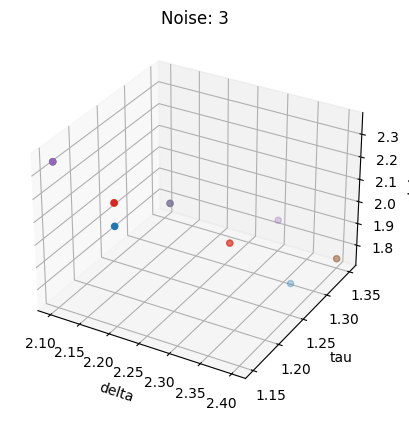

In [64]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

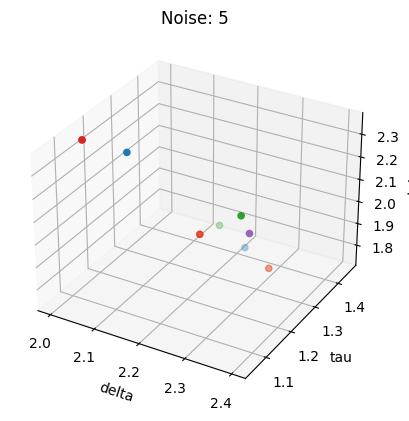

In [65]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

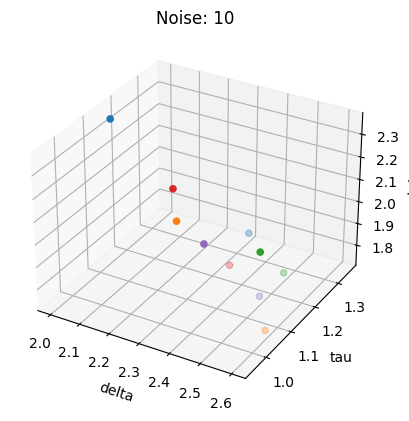

In [66]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()